In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [5]:
df=pd.read_csv(r"cleaned_data/gurgaon_properties_cleaned.csv")

In [7]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
0,flat,experion windchants,sector 112,4.75,12622.0,3763.0,Super Built up area 3763(349.59 sq.m.),3,5,3+,servant room,4.0,West,1 to 5 Year Old,"['Ansal Plaza', 'Dwaraka Expressway', 'First Step Play School', 'Sri Ma Montessori International', 'Jai Sai Ram Hospital', 'Park Hospital', 'IGI Airport', 'Gurgaon Railway Station']","['1 Water Purifier', '5 Geyser', '1 Chimney', '1 Modular Kitchen', '5 AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']"


### areaWithType

Three Types of Area  
1. Super Built Up Area : outside area of balcony , stairs + built up + carpet area
2. Built Up Area : carpet area + thickness of the walls 
2. Carpet Area : rooms,washroom ,kitchen etc area


In [8]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
499,2.00,2087.0,Super Built up area 2087(193.89 sq.m.)
3239,2.00,1967.0,Carpet area: 1967 (182.74 sq.m.)
1512,1.07,1385.0,Super Built up area 1385(128.67 sq.m.)
2697,1.50,1185.0,Super Built up area 1400(130.06 sq.m.)Built Up area: 1385 sq.ft. (128.67 sq.m.)Carpet area: 1185 sq.ft. (110.09 sq.m.)
8,0.72,1081.0,Super Built up area 1081(100.43 sq.m.)


The Column [area] is not giving accurate information and inconsistent values. sometimes it gives built area or carpet values .So extracting three types of area separately.

In [9]:
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

In [10]:
# Built up and carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

### AreawithType
Area is given in multiple metrics,creating function to checks if the area is provided in sq.m. and then converts it to sqft if needed

In [11]:
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # sq.m. to sqft
    return area_value

In [12]:
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

In [13]:
# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

In [14]:
# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [15]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
1716,0.97,flat,1050.0,Carpet area: 1050 (97.55 sq.m.),NaN,NaN,1050.0
668,1.50,flat,1640.0,Super Built up area 1640(152.36 sq.m.),1640.0,NaN,NaN
1412,1.87,flat,2404.0,Super Built up area 2408(223.71 sq.m.)Built Up area: 2225 sq.ft. (206.71 sq.m.)Carpet area: 2175 sq.ft. (202.06 sq.m.),2408.0,2225.0,2175.0
2473,2.36,flat,1650.0,Super Built up area 1650(153.29 sq.m.),1650.0,NaN,NaN
3489,6.25,flat,2572.0,Carpet area: 2880 (267.56 sq.m.),NaN,NaN,2880.0


In [16]:
df.duplicated().sum()

np.int64(122)

In [18]:
# Extracting rows which have all three types of area as we will use it for imputing
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].shape


(534, 7)

### House Data Plot 
- Flats have three types of area 
- Houses have plot area 

In [19]:
df[df['areaWithType'].str.contains('Plot')][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].head(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
4,9.85,house,3323.0,Plot area 418(349.5 sq.m.),NaN,NaN,NaN
7,9.50,house,4071.0,Plot area 500(418.06 sq.m.),NaN,NaN,NaN
9,7.42,house,2160.0,Plot area 2160(200.67 sq.m.)Built Up area: 3200 sq.ft. (297.29 sq.m.),NaN,3200.0,NaN
16,6.81,house,1845.0,Plot area 205(171.41 sq.m.),NaN,NaN,NaN
24,7.00,house,2700.0,Plot area 300(250.84 sq.m.),NaN,NaN,NaN


In [20]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2616
carpet_area            1859
dtype: int64

In [21]:
all_nan_df = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']]


In [22]:
all_nan_df.head()


,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
4,9.85,house,3323.0,Plot area 418(349.5 sq.m.),NaN,NaN,NaN
7,9.50,house,4071.0,Plot area 500(418.06 sq.m.),NaN,NaN,NaN
16,6.81,house,1845.0,Plot area 205(171.41 sq.m.),NaN,NaN,NaN
24,7.00,house,2700.0,Plot area 300(250.84 sq.m.),NaN,NaN,NaN
25,23.00,house,9000.0,Plot area 1000(836.13 sq.m.),NaN,NaN,NaN


In [23]:
all_nan_index = df[((df['super_built_up_area'].isnull()) & (df['built_up_area'].isnull()) & (df['carpet_area'].isnull()))][['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].index


In [24]:
# Function To extract plot area
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [25]:
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)

### Data discrepency as plot area is in sq_yard -> convert to sqft 

In [26]:
all_nan_df

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
4,9.85,house,3323.0,Plot area 418(349.5 sq.m.),NaN,418.00,NaN
7,9.50,house,4071.0,Plot area 500(418.06 sq.m.),NaN,500.00,NaN
16,6.81,house,1845.0,Plot area 205(171.41 sq.m.),NaN,205.00,NaN
24,7.00,house,2700.0,Plot area 300(250.84 sq.m.),NaN,300.00,NaN
25,23.00,house,9000.0,Plot area 1000(836.13 sq.m.),NaN,1000.00,NaN
29,11.95,house,3240.0,Plot area 360(301.01 sq.m.),NaN,360.00,NaN
33,4.25,house,1836.0,Plot area 204(170.57 sq.m.),NaN,204.00,NaN
38,2.70,house,1450.0,Plot area 1450(134.71 sq.m.),NaN,1450.00,NaN
41,4.95,house,2403.0,Plot area 267(223.25 sq.m.),NaN,267.00,NaN
51,4.50,house,1350.0,Plot area 150(125.42 sq.m.),NaN,150.00,NaN


In [29]:
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']

In [30]:
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)

In [31]:
df.update(all_nan_df)

In [32]:
df.isnull().sum()

property_type             0
society                   1
sector                    0
price                    18
price_per_sqft           18
area                     18
areaWithType              0
bedRoom                   0
bathroom                  0
balcony                   0
additionalRoom            0
floorNum                 19
facing                 1105
agePossession             1
nearbyLocations         177
furnishDetails          981
features                635
super_built_up_area    1888
built_up_area          2070
carpet_area            1859
dtype: int64

In [33]:
df.head(1)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area
0,flat,experion windchants,sector 112,4.75,12622.0,3763.0,Super Built up area 3763(349.59 sq.m.),3,5,3+,servant room,4.0,West,1 to 5 Year Old,"['Ansal Plaza', 'Dwaraka Expressway', 'First Step Play School', 'Sri Ma Montessori International', 'Jai Sai Ram Hospital', 'Park Hospital', 'IGI Airport', 'Gurgaon Railway Station']","['1 Water Purifier', '5 Geyser', '1 Chimney', '1 Modular Kitchen', '5 AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']",3763.0,NaN,NaN


### additionalRoom Column cleaning

In [34]:
df['additionalRoom'].value_counts()

additionalRoom
not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
study room,servant room                            99
store room                                         99
pooja room,servant room                            82
pooja room,study room,servant room,store room      72
servant room,others                                60
pooja room,study room,servant room                 55
pooja room,study room,servant room,others          54
servant room,pooja room                            38
servant room,store room                            33
study room,others                                  29
pooja room,study room                              22
pooja room,others                                  17
pooja room,store room                              15
pooja room,st

In [35]:
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

In [38]:
## Kind of one hot encoding not excatly
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)

In [39]:
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
2677,"servant room,study room,pooja room,store room",1,1,1,1,0
780,not available,0,0,0,0,0
1871,"study room,others",1,0,0,0,1
1955,servant room,0,1,0,0,0
2285,not available,0,0,0,0,0


In [40]:
df.head()

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others
0,flat,experion windchants,sector 112,4.75,12622.0,3763.0,Super Built up area 3763(349.59 sq.m.),3,5,3+,servant room,4.0,West,1 to 5 Year Old,"['Ansal Plaza', 'Dwaraka Expressway', 'First Step Play School', 'Sri Ma Montessori International', 'Jai Sai Ram Hospital', 'Park Hospital', 'IGI Airport', 'Gurgaon Railway Station']","['1 Water Purifier', '5 Geyser', '1 Chimney', '1 Modular Kitchen', '5 AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']",3763.0,NaN,NaN,0,1,0,0,0
1,flat,ild greens,sector 37c,0.90,5614.0,1603.0,Super Built up area 1603(148.92 sq.m.)Built Up area: 1500 sq.ft. (139.35 sq.m.),3,3,3,not available,0.0,North-East,Under Construction,"['The Esplanade Mall', 'Gurgaon Road', 'Delhi Jaipur Expressway', 'Green Field Public School', 'Sunrise University', 'K.D. Hospital', 'Indira Gandhi International Airport', 'Gurgaon Railway Station', 'infinity Business Park']",NaN,"['Lift(s)', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Security / Fire Alarm', 'Swimming Pool', 'Park', 'Visitor Parking', 'Piped-gas', 'Club house / Community Center', 'Fitness Centre / GYM', 'Water softening plant', 'Rain Water Harvesting', 'Shopping Centre']",1603.0,1500.0,NaN,0,0,0,0,0
2,flat,breez global hill view,sohna road,0.32,5470.0,585.0,Built Up area: 1000 (92.9 sq.m.)Carpet area: 585 sq.ft. (54.35 sq.m.),2,2,1,not available,17.0,NaN,0 to 1 Year Old,"['Huda City Centre', 'Omaxe City Centre', 'Ninex City Mart', 'Vaels Ravindra Bharathi Global School', 'Anjali nursery', 'Polaris Hospital', 'Axis Bank', 'Triangular Park', 'Flow Sports Life Badminton Club', 'Basai Dhankot Railway Station', 'Cars24', 'Radisson Hotel Gurugram', ""McDonald's"", 'Petrol Pump', 'Indian Post Office']",[],"['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking']",NaN,1000.0,585.0,0,0,0,0,0
3,flat,signature global synera,sector 81,0.45,7525.0,598.0,Carpet area: 598 (55.56 sq.m.),2,2,2,store room,6.0,North-East,1 to 5 Year Old,"['Sapphire 83 Mall', 'Delhi Jaipur Expressway', 'Dwarka Expressway', 'Agri Business Management Collage', 'Bharat Ram Global School', 'Singhania University, Manesar', 'Aarvy Healthcare Hospital', 'Garhi Harsaru Junction', 'Sphire Edge A N Buildwell', 'Holiday Inn Gurugram Sector 90']","['3 Wardrobe', '3 Fan', '1 Exhaust Fan', '2 Geyser', '5 Light', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Power Back-up', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking', 'Security Personnel']",NaN,NaN,598.0,0,0,1,0,0
4,house,independent,sector 43,9.85,29638.0,3323.0,Plot area 418(349.5 sq.m.),5,5,2,"pooja room,study room,servant room",3.0,West,10+ Year Old,"['Mg road metro station', 'Iffco chowk metro station', 'Arya Samaj Mandir', 'Jain Bhawan', 'Hanuman Mandir', 'Axis bank ATM', 'Punjab national bank ATM', 'Icici bank ATM', 'Standard chartered ATM', 'Kotak mahindra bank ATM', 'Sidhesh Hospital Gurgaon', 'Lord Krishna Hospital', 'Privat Hospital', 'Uma Sanjeevani Health Centre And Hospital', 'Surgi Center Clinic', 'Umkal Hospital', 'Sitaram Bhartia', 'Religare Wellness', '98.4', 'Guardian', 'DLF Cyber City Phase II', 'DT Cinemas', 'PVR Metropolitan', 'PVR Cinames', 'DT Cinemas', 'PVR Cinames', 'Indusind bank', 'Abn amro bank', 'Lord

### AgePossession

In [41]:
df['agePossession'].value_counts()

agePossession
1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Oct 2024                 8
Jan 2024                 8
Jun 2024                 7
Dec 2025                 7
Aug 2023                 7
Nov 2023                 5
Sep 2023                 4
Jul 2024                 4
By 2025                  4
Oct 2023                 4
Aug 2024                 4
Jan 2025                 3
Feb 2024                 3
May 2024                 3
Nov 2024                 3
Aug 2025                 2
Jun 2027                 2
Dec 2026                 2
Jul 2027                 2
Oct 2025                 2
Mar 2025                 2
Apr 2026                 2
Jul 2025                 2
By 2027       

In [43]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        int(value.split(" ")[-1]) #'value : jun 2028'
        return "Under Construction"
    except:
        return "Undefined"

In [44]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [46]:
df.agePossession.value_counts()

agePossession
Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: count, dtype: int64

### FurnishDetails Column FE

In [47]:
df.sample(5)[['furnishDetails','features']]

,furnishDetails,features
714,[],"['Intercom Facility', 'Security / Fire Alarm', 'Private Garden / Terrace', 'Park', 'Maintenance Staff', 'Visitor Parking', 'Water Storage', 'Piped-gas', 'Swimming Pool', 'Security Personnel', 'Natural Light', 'High Ceiling Height', 'Club house / Community Center', 'Fitness Centre / GYM', 'Water softening plant', 'Rain Water Harvesting', 'Shopping Centre']"
3492,"['1 Bed', '1 Wardrobe', '1 Water Purifier', '3 Fan', '1 Exhaust Fan', '8 Light', '1 AC', '1 Modular Kitchen', '6 Curtains', 'No Chimney', 'No Dining Table', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Park']"
63,"['1 Fan', '1 Geyser', '1 Stove', '1 Light', '1 AC', '1 Modular Kitchen', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Swimming Pool', 'Fitness Centre / GYM', 'Club house / Community Center']"
412,"['1 Exhaust Fan', '1 Stove', '1 Light', '1 AC', '1 Chimney', 'No Bed', 'No Curtains', 'No Dining Table', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']","['Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Internet/wi-fi connectivity', 'Low Density Society', 'Shopping Centre', 'Fitness Centre / GYM', 'Rain Water Harvesting', 'Club house / Community Center']"
1599,"['11 Wardrobe', '7 Fan', '1 Exhaust Fan', '11 Geyser', '17 Light', '9 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']","['Feng Shui / Vaastu Compliant', 'Maintenance Staff', 'Water Storage', 'Park', 'Visitor Parking', 'Waste Disposal', 'Rain Water Harvesting']"


In [48]:
df.furnishDetails.isnull().sum()

np.int64(981)

### First creating 18 items as columns and then on that data performing clustering and based on that we give value as furnished ,semi furnished and not furnished 

In [56]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))  #set removes dupliactes -> unique items

In [57]:
unique_furnishings

['',
 '30 Light',
 '2 Geyser',
 '40 Light',
 '1 Dining Table',
 '13 Light',
 '41 Light',
 '12 Wardrobe',
 '17 Light',
 '21 Fan',
 '49 Light',
 '16 Wardrobe',
 '7 Light',
 '9 Bed',
 '94 Light',
 'No Curtains',
 '1 Fridge',
 '16 Fan',
 '6 Light',
 '15 Light',
 '8 Wardrobe',
 '43 Light',
 '20 AC',
 '69 Light',
 '12 TV',
 '4 Curtains',
 '3 Curtains',
 '7 Wardrobe',
 '10 Geyser',
 '55 Light',
 '15 Wardrobe',
 '18 Chimney',
 '22 Wardrobe',
 '18 Light',
 '56 Light',
 '36 Fan',
 'No Washing Machine',
 '2 Light',
 '24 Wardrobe',
 '50 Light',
 '18 AC',
 '5 Bed',
 '9 Geyser',
 '20 Bed',
 '6 Curtains',
 '11 AC',
 '2 TV',
 '21 Bed',
 '9 Light',
 '3 Chimney',
 '13 Fan',
 '1 Wardrobe',
 '12 Fan',
 '2 Chimney',
 '13 Wardrobe',
 '14 Wardrobe',
 '5 TV',
 '8 Bed',
 '15 Geyser',
 '10 AC',
 '2 Wardrobe',
 '4 Bed',
 '26 Light',
 '12 Geyser',
 '78 Light',
 '10 Wardrobe',
 '18 Wardrobe',
 '15 Fan',
 '5 Light',
 '51 Light',
 'No TV',
 'No AC',
 '12 Bed',
 'No Exhaust Fan',
 '4 Light',
 '1 Geyser',
 '38 Fan',
 

In [ ]:
# function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

In [60]:
# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

In [61]:
# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]

In [62]:
furnishings_df.shape

(3803, 19)

In [63]:
furnishings_df.drop(columns=['furnishDetails'],inplace=True)


C:\Users\karth\AppData\Local\Temp\ipykernel_14176\2609480216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


In [64]:
furnishings_df.sample(5)

,Stove,Geyser,Chimney,AC,Sofa,Modular Kitchen,Exhaust Fan,Dining Table,TV,Water Purifier,Fan,Light,Curtains,Microwave,Washing Machine,Bed,Wardrobe,Fridge
3137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
661,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
786,0,3,1,0,0,1,1,0,0,0,5,5,0,0,0,0,0,0
3176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2761,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Clustering on furnishing data to decide which clusters as furnished , semi furnished and unfurnished
- number of clusters is decided based on elbow method graph. the point where slope reduction rate is very less .

In [65]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [67]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [68]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

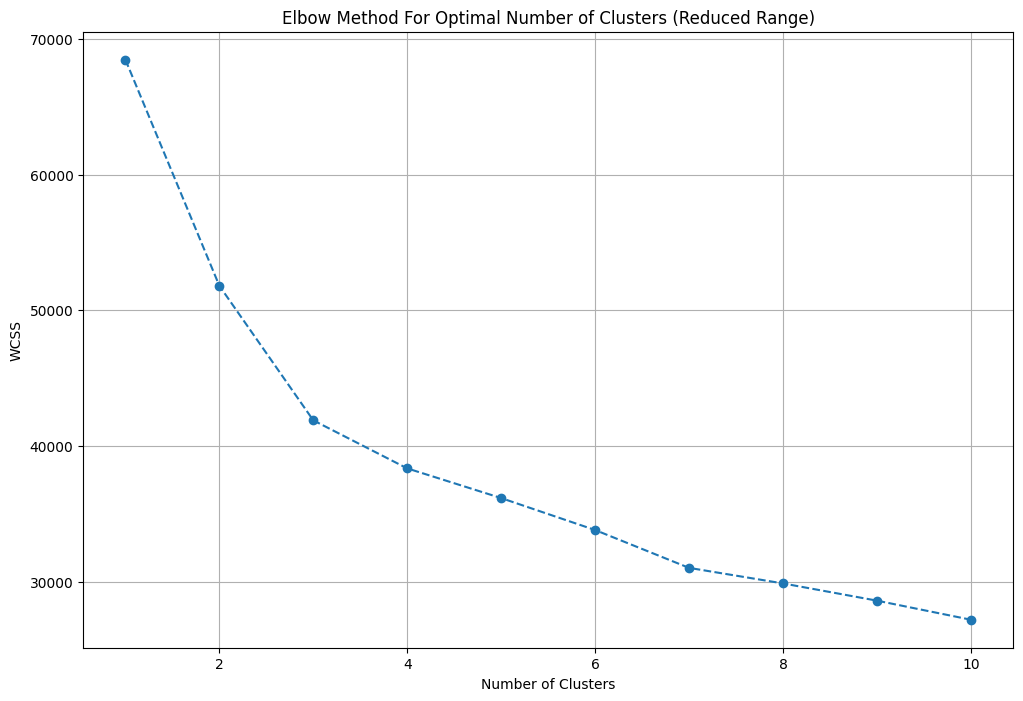

In [69]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [70]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [71]:
df = df.iloc[:,:-18]

In [72]:
df['furnishing_type'] = cluster_assignments

In [76]:
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
2794,"['1 Light', 'No AC', 'No Bed', 'No Chimney', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Geyser', 'No Modular Kitchen', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine', 'No Water Purifier']",1
2039,"['3 Wardrobe', '1 Water Purifier', '6 Fan', '1 Exhaust Fan', '3 Geyser', '1 Chimney', '1 Modular Kitchen', 'No AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine']",0
3764,[],1
3766,"['2 Wardrobe', '3 Fan', '1 Exhaust Fan', '12 Light', '1 Modular Kitchen', '5 Curtains', 'No AC', 'No Bed', 'No Chimney', 'No Dining Table', 'No Geyser', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Washing Machine', 'No Water Purifier']",0
1131,NaN,1


### Features Column

#### Features column has a long list of values. it has 600+ missing values since i have apartment data where facility column is available i can fill those values by merging apartment['property_name'] with df['society']. temp_df for nan values .

In [77]:
df[['society','features']].sample(5)

,society,features
1438,m3m skywalk,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Private Garden / Terrace', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Bank Attached Property', 'Piped-gas', 'Internet/wi-fi connectivity', 'Recently Renovated', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Low Density Society', 'Waste Disposal', 'Rain Water Harvesting', 'Water softening plant', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"
2613,eldeco accolade,NaN
2892,independent,['Water Storage']
2588,indiabulls enigma,NaN
759,puri the aravallis,"['Centrally Air Conditioned', 'Water purifier', 'Security / Fire Alarm', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Lift(s)', 'High Ceiling Height', 'Maintenance Staff', 'False Ceiling Lighting', 'Water Storage', 'Separate entry for servant room', 'No open drainage around', 'Piped-gas', 'Internet/wi-fi connectivity', 'Visitor Parking', 'Swimming Pool', 'Park', 'Security Personnel', 'Natural Light', 'Airy Rooms', 'Spacious Interiors', 'Waste Disposal', 'Rain Water Harvesting', 'Shopping Centre', 'Fitness Centre / GYM', 'Club house / Community Center']"


In [78]:
df['features'].isnull().sum()

np.int64(635)

### Apartment Data 

In [82]:
app_df = pd.read_csv(r"data/appartments.csv")

In [83]:
app_df['PropertyName'] = app_df['PropertyName'].str.lower()

In [84]:
temp_df = df[df['features'].isnull()]

In [85]:
temp_df.shape


(635, 26)

In [86]:
x = temp_df.merge(app_df,left_on='society',right_on='PropertyName',how='left')['TopFacilities']

In [87]:
df.loc[temp_df.index,'features'] = x.values

In [88]:
df['features'].isnull().sum()

np.int64(481)

In [89]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [90]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [91]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,Bank Attached Property,Banquet Hall,Bar/Chill-Out Lounge,Barbecue,Basketball Court,Beach Volley Ball Court,Billiards,Bowling Alley,Bus Shelter,Business Lounge,CCTV Camera Security,Cafeteria,Car Parking,Car wash area,Card Room,Centrally Air Conditioned,Changing Area,Children's Play Area,Cigar Lounge,Clinic,Club House,Club house / Community Center,Community Hall,Concierge Service,Conference room,Creche/Day care,Cricket Pitch,Doctor on Call,Earthquake Resistant,Entrance Lobby,False Ceiling Lighting,Feng Shui / Vaastu Compliant,Fire Fighting Systems,Fitness Centre / GYM,Flower Garden,Food Court,Foosball,Football,Fountain,Gated Community,Gazebo,Golf Course,Grocery Shop,Gymnasium,High Ceiling Height,High Speed Elevators,Infinity Pool,Intercom Facility,Internal Street Lights,Internet/wi-fi connectivity,Jacuzzi,Jogging Track,Landscape Garden,Laundry,Lawn Tennis Court,Library,Lift(s),Lounge,Low Density Society,Maintenance Staff,Manicured Garden,Medical Centre,Milk Booth,Mini Theatre,Multipurpose Court,Multipurpose Hall,Natural Light,Natural Pond,No open drainage around,Park,Party Lawn,Pergola,Piped Gas,Piped-gas,Pool Table,Power Back up Lift,Power Back-up,Private Garden / Terrace,Property Staff,RO System,Rain Water Harvesting,Reading Lounge,Recently Renovated,Reflexology Park,Restaurant,Salon,Sauna,School,Security / Fire Alarm,Security Personnel,Separate entry for servant room,Sewage Treatment Plant,Shopping Centre,Skating Rink,Solar Lighting,Solar Water Heating,Spa,Spacious Interiors,Squash Court,Steam Room,Sun Deck,Swimming Pool,Temple,Terrace Garden,Theatre,Toddler Pool,Valet Parking,Vastu Compliant,Video Door Security,Visitor Parking,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
2532,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0
1681,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0
3795,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2854,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
2741,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
features_binary_df.shape


(3803, 130)

In [93]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

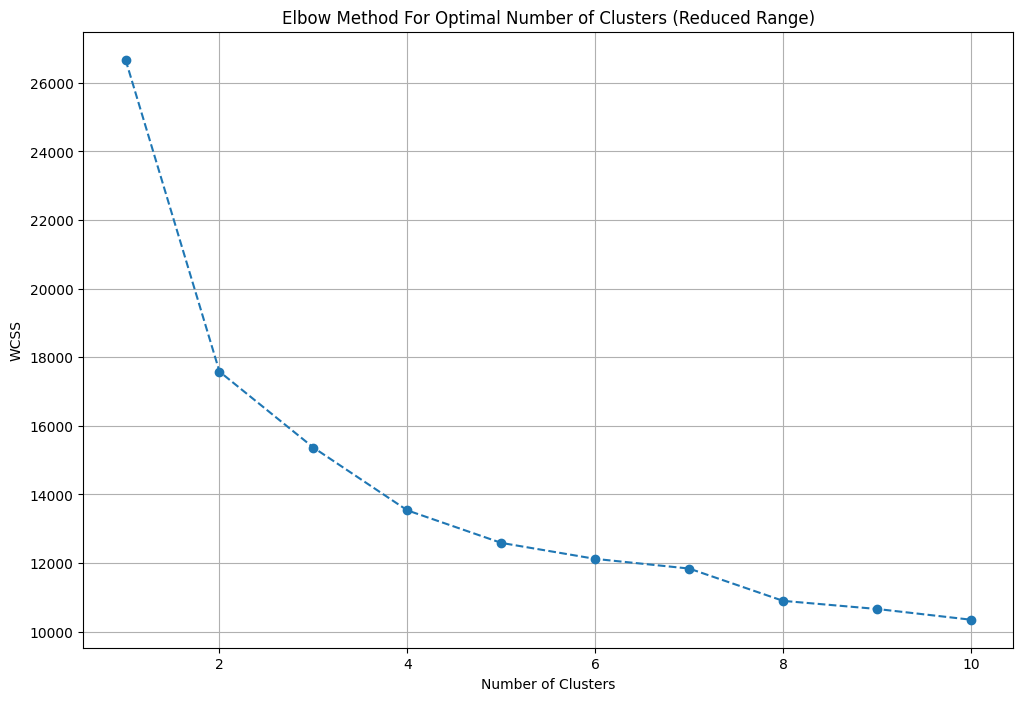

In [94]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

#### since approach was to make features as cateogrical column having values as luxury , semi-luxury and budget.Tried k-means clustering and elbow methods says only two clusters to be made and by checking it show all NaN values as budget rest as luxury so dropped the idea.

In [ ]:
# Assigning weights based on perceived luxury contribution with the gpt help
weights = {
    '24/7 Power Backup': 8,
    '24/7 Water Supply': 4,
    '24x7 Security': 7,
    'ATM': 4,
    'Aerobics Centre': 6,
    'Airy Rooms': 8,
    'Amphitheatre': 7,
    'Badminton Court': 7,
    'Banquet Hall': 8,
    'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7,
    'Basketball Court': 7,
    'Billiards': 7,
    'Bowling Alley': 8,
    'Business Lounge': 9,
    'CCTV Camera Security': 8,
    'Cafeteria': 6,
    'Car Parking': 6,
    'Card Room': 6,
    'Centrally Air Conditioned': 9,
    'Changing Area': 6,
    "Children's Play Area": 7,
    'Cigar Lounge': 9,
    'Clinic': 5,
    'Club House': 9,
    'Concierge Service': 9,
    'Conference room': 8,
    'Creche/Day care': 7,
    'Cricket Pitch': 7,
    'Doctor on Call': 6,
    'Earthquake Resistant': 5,
    'Entrance Lobby': 7,
    'False Ceiling Lighting': 6,
    'Feng Shui / Vaastu Compliant': 5,
    'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [96]:
df['luxury_score'] = luxury_score


In [97]:
df.head(2)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
0,flat,experion windchants,sector 112,4.75,12622.0,3763.0,Super Built up area 3763(349.59 sq.m.),3,5,3+,servant room,4.0,West,Relatively New,"['Ansal Plaza', 'Dwaraka Expressway', 'First Step Play School', 'Sri Ma Montessori International', 'Jai Sai Ram Hospital', 'Park Hospital', 'IGI Airport', 'Gurgaon Railway Station']","['1 Water Purifier', '5 Geyser', '1 Chimney', '1 Modular Kitchen', '5 AC', 'No Bed', 'No Curtains', 'No Dining Table', 'No Exhaust Fan', 'No Fan', 'No Light', 'No Microwave', 'No Fridge', 'No Sofa', 'No Stove', 'No TV', 'No Wardrobe', 'No Washing Machine']","['Feng Shui / Vaastu Compliant', 'Security / Fire Alarm', 'Intercom Facility', 'Lift(s)', 'Maintenance Staff', 'Park', 'Visitor Parking']",3763.0,NaN,NaN,0,1,0,0,0,0,"[Feng Shui / Vaastu Compliant, Security / Fire Alarm, Intercom Facility, Lift(s), Maintenance Staff, Park, Visitor Parking]",42
1,flat,ild greens,sector 37c,0.90,5614.0,1603.0,Super Built up area 1603(148.92 sq.m.)Built Up area: 1500 sq.ft. (139.35 sq.m.),3,3,3,not available,0.0,North-East,Under Construction,"['The Esplanade Mall', 'Gurgaon Road', 'Delhi Jaipur Expressway', 'Green Field Public School', 'Sunrise University', 'K.D. Hospital', 'Indira Gandhi International Airport', 'Gurgaon Railway Station', 'infinity Business Park']",NaN,"['Lift(s)', 'Feng Shui / Vaastu Compliant', 'Intercom Facility', 'Security / Fire Alarm', 'Swimming Pool', 'Park', 'Visitor Parking', 'Piped-gas', 'Club house / Community Center', 'Fitness Centre / GYM', 'Water softening plant', 'Rain Water Harvesting', 'Shopping Centre']",1603.0,1500.0,NaN,0,0,0,0,0,1,"[Lift(s), Feng Shui / Vaastu Compliant, Intercom Facility, Security / Fire Alarm, Swimming Pool, Park, Visitor Parking, Piped-gas, Club house / Community Center, Fitness Centre / GYM, Water softening plant, Rain Water Harvesting, Shopping Centre]",66


In [98]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [99]:
df.shape


(3803, 23)

In [100]:
df.to_csv('gurgaon_properties_cleaned_v2.csv',index=False)